In [126]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib
import random
import IPython.display as display

In [127]:
data_dir = '../dataset/2_class'

In [128]:
data_root = pathlib.Path(data_dir)

In [129]:
for item in data_root.iterdir():
    print(item)

..\dataset\2_class\airplane
..\dataset\2_class\lake


In [130]:
# 将所有图片路径取出来，放到list中
all_image_path_wh = list(data_root.glob('*/*'))

In [131]:
all_image_path = [str(path) for path in all_image_path_wh]

In [132]:
# 做一个乱序
random.shuffle(all_image_path)

In [133]:
# 记录图片个数用于训练集和test集的划分
image_count = len(all_image_path)

In [134]:
# 提取label
label_names = sorted(item.name for item in data_root.glob('*/'))

In [135]:
# 把label转换成dict结构
label_to_index = dict((name, index) for index, name in enumerate(label_names))

In [136]:
all_image_label = [label_to_index[pathlib.Path(p).parent.name] for p in all_image_path]
# 这种也行只是没做乱序
# all_image_label = [label_to_index[p.parent.name] for p in all_image_path_wh]

In [137]:
index_to_label = dict((v,k) for k,v in label_to_index.items())

In [138]:
# 显示图片的方法
# for n in range(3):
#     image_index = random.choice(range(len(all_image_path)))
#     display.display(display.Image(all_image_path[image_index]))
#     print(index_to_label[all_image_label[image_index]])
#     print()

In [139]:
# img_path = all_image_path[0]

In [140]:
# 读取图片
# img_raw = tf.io.read_file(img_path)

In [141]:
# 解码图片
# img_tensor = tf.image.decode_jepg(img_raw)


In [142]:
# img_tensor.dtype

In [143]:
# 转换数据类型
# img_tensor = tf.cast(img_tensor, tf.float32)

In [144]:
# 数据标准化,转换到0-1之间
# img_tensor = img_tensor / 255

In [145]:
# 将上面的流程抽象成一个函数
def load_preprocess_image(img_path):
    img_raw = tf.io.read_file(img_path)
    img_tensor = tf.image.decode_jpeg(img_raw, channels=3)
    # resize改变图片的大小
    img_tensor = tf.image.resize(img_tensor, [256, 256])
    img_tensor = tf.cast(img_tensor, tf.float32)
    img = img_tensor / 255
    return img

In [146]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_path)

In [147]:
image_dataset = path_ds.map(load_preprocess_image)

In [148]:
label_dataset = tf.data.Dataset.from_tensor_slices(all_image_label)

In [150]:
# 数据合并
dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

In [151]:
test_count = int(image_count * 0.2)
train_count = image_count - test_count

In [152]:
train_dataset = dataset.skip(test_count)
test_dataset = dataset.take(test_count)

In [153]:
BATCH_SIZE = 32

In [154]:
# 乱序并且一直产生数据
# train_dataset = train_dataset.repeat().shuffle(buffer_size=train_count).batch(BATCH_SIZE)
train_dataset = train_dataset.shuffle(buffer_size=train_count).batch(BATCH_SIZE)

In [155]:
test_dataset = test_dataset.batch(BATCH_SIZE)

In [161]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape=(256,256,3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu'))
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3,3), activation='relu'))
model.add(tf.keras.layers.Conv2D(512, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(1024, (3,3), activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [162]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 254, 64)      1792      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 252, 252, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 124, 124, 128)     73856     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 122, 122, 128)     147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 61, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 59, 59, 256)      

In [163]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

In [164]:
steps_per_epoch = train_count // BATCH_SIZE
validation_steps = test_count // BATCH_SIZE

In [165]:
history = model.fit(
    train_dataset,
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps
)

Epoch 1/30
35/35 [==============================] - 17s 483ms/step - loss: 0.7766 - acc: 0.5437 - val_loss: 0.6525 - val_acc: 0.5312

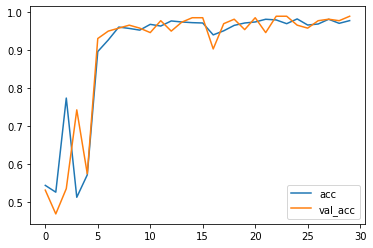

In [166]:
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()

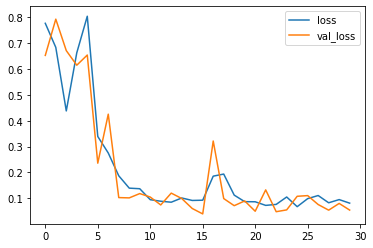

In [167]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()